In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

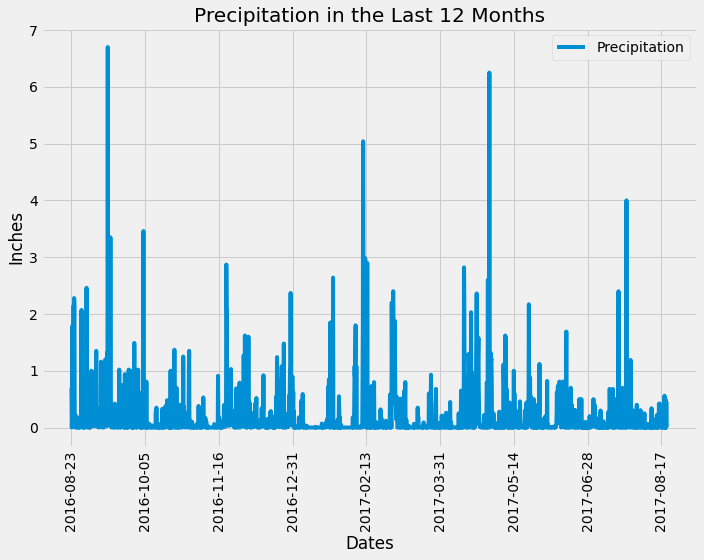

In [10]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

query_month = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_month = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= "2016-08-23").\
                    filter(Measurement.prcp.isnot(None)).\
                    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_month_df = pd.DataFrame(precipitation_month, columns=["date","prcp"]).rename(columns={"prcp":"Precipitation"})
precipitation_month_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_month_graph = precipitation_month_df.sort_index(axis=0, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_month_graph.plot(figsize=(10,8),title="Precipitation in the Last 12 Months", rot=90)
plt.ylabel("Inches")
plt.xlabel("Dates")
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_month_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [12]:
# Look up the variables in measurement table
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fa5a7f6b630>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [13]:
# Look up the variables in station table
Station_first_row = session.query(Station).first()
Station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fa5a7fd5358>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168}

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [15]:
session.query(Station.station).group_by(Station.station).all()

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Measurement.station)).\
            filter(Station.station == Measurement.station).\
            group_by(Station.station).\
            order_by(func.count(Station.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
most_active_query = session.query(Station.station).filter(Station.station == Measurement.station).\
            group_by(Station.station).\
            order_by(func.count(Station.station).desc()).first()
most_active_query

('USC00519281')

In [18]:
# I didn't want to hard code it, so I used https://www.geeksforgeeks.org/python-convert-tuple-to-float-value/ as reference to set this up
most_active = str(''.join(most_active_query))
most_active

'USC00519281'

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

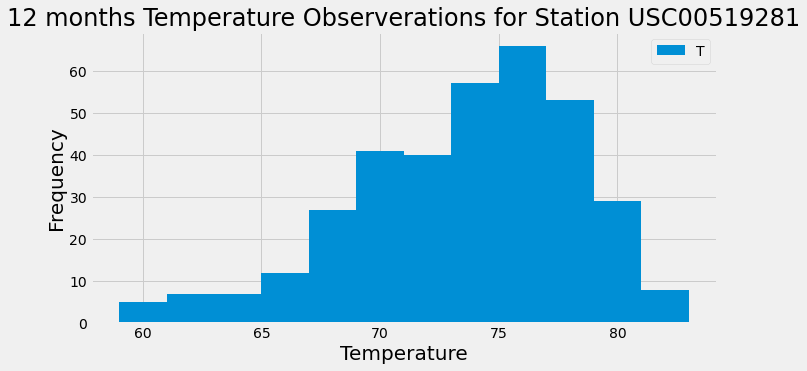

In [21]:
# Choose the station with the highest number of temperature observations.
most_tobs_query = session.query(Measurement.station).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).first()

most_tobs = str(''.join(most_tobs_query))

temp_obs = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == most_tobs).\
                    filter(Measurement.date >= "2016-08-23").\
                    filter(Measurement.prcp.isnot(None)).\
                    order_by(Measurement.date).all()

temperature_obs = [temp_ob[1] for temp_ob in temp_obs[:]]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
x = temperature_obs 
num_bins = 12


plt.figure(figsize=(10,5))
plt.hist(x, num_bins)
plt.legend("Tobs")

plt.xlabel('Temperature', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('12 months Temperature Observerations for Station USC00519281', fontsize=24)
plt.show()

In [47]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.date >= "2016-08-23").\
            group_by(Measurement.date).all()

[(74.0, 81.0, 78.28571428571429),
 (74.0, 80.0, 77.57142857142857),
 (77.0, 81.0, 79.42857142857143),
 (78.0, 84.0, 80.5),
 (73.0, 81.0, 76.83333333333333),
 (71.0, 81.0, 76.0),
 (78.0, 80.0, 78.71428571428571),
 (75.0, 79.0, 77.33333333333333),
 (76.0, 80.0, 78.28571428571429),
 (77.0, 82.0, 80.16666666666667),
 (75.0, 81.0, 79.42857142857143),
 (75.0, 79.0, 77.4),
 (73.0, 84.0, 77.0),
 (76.0, 84.0, 79.5),
 (73.0, 80.0, 75.66666666666667),
 (74.0, 80.0, 75.83333333333333),
 (74.0, 81.0, 78.71428571428571),
 (75.0, 79.0, 77.42857142857143),
 (75.0, 78.0, 76.8),
 (71.0, 83.0, 77.2),
 (72.0, 79.0, 76.85714285714286),
 (75.0, 79.0, 77.57142857142857),
 (73.0, 79.0, 75.85714285714286),
 (73.0, 81.0, 77.85714285714286),
 (73.0, 80.0, 77.85714285714286),
 (76.0, 81.0, 78.6),
 (75.0, 81.0, 78.6),
 (70.0, 79.0, 76.57142857142857),
 (70.0, 80.0, 75.85714285714286),
 (73.0, 80.0, 76.66666666666667),
 (73.0, 79.0, 76.57142857142857),
 (73.0, 82.0, 78.57142857142857),
 (77.0, 83.0, 80.166666666666

In [51]:
list(np.ravel(session.query(Measurement.date).all()))

['2010-01-01',
 '2010-01-02',
 '2010-01-03',
 '2010-01-04',
 '2010-01-06',
 '2010-01-07',
 '2010-01-08',
 '2010-01-09',
 '2010-01-10',
 '2010-01-11',
 '2010-01-12',
 '2010-01-14',
 '2010-01-15',
 '2010-01-16',
 '2010-01-17',
 '2010-01-18',
 '2010-01-19',
 '2010-01-20',
 '2010-01-21',
 '2010-01-22',
 '2010-01-23',
 '2010-01-24',
 '2010-01-25',
 '2010-01-26',
 '2010-01-27',
 '2010-01-28',
 '2010-01-30',
 '2010-01-31',
 '2010-02-01',
 '2010-02-03',
 '2010-02-04',
 '2010-02-05',
 '2010-02-06',
 '2010-02-07',
 '2010-02-08',
 '2010-02-09',
 '2010-02-11',
 '2010-02-12',
 '2010-02-13',
 '2010-02-14',
 '2010-02-15',
 '2010-02-16',
 '2010-02-17',
 '2010-02-19',
 '2010-02-20',
 '2010-02-21',
 '2010-02-22',
 '2010-02-23',
 '2010-02-24',
 '2010-02-25',
 '2010-02-26',
 '2010-02-28',
 '2010-03-01',
 '2010-03-02',
 '2010-03-03',
 '2010-03-04',
 '2010-03-05',
 '2010-03-06',
 '2010-03-07',
 '2010-03-08',
 '2010-03-09',
 '2010-03-11',
 '2010-03-12',
 '2010-03-13',
 '2010-03-14',
 '2010-03-15',
 '2010-03-

## Bonus Challenge Assignment

In [49]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
